In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

df = pd.read_csv('../data/clean.csv')

In [18]:
df['FinalStatusYear'] = df['FinalStatusDate'].transform(lambda x: int(x / 365))

## Standard Preprocessor Encoding

- It may appear that some categorical columns like BusinessAge or InitialInterestRate should be classified as either ordinal or categorical, however these columns are correctly classified as categorical since they do not admit a clear ordering. In particular, BusinessAge  has classifications like "Transfer of Ownership" as well as indicators of age which can be well ordered. The same is true for InitialIntrestRate, which has a significant number of classifications as "Unknown".

In [19]:
continuous_columns = ['GrossApproval', 'SBAGuaranteedApproval', 'LoanAssuranceRatio', 'JobsSupported', 'TermInMonths', 
                      'ApprovalDate', 'FirstDisbursementDate']
categorical_columns = ['DeliveryMethod', 'Subprogram', 
                       'InitialInterestRate', 'FixedOrVariableInterestInd', 'FranchiseCode',
                       'ProjectState', 'CongressionalDistrict', 'BusinessType', 
                       'BusinessAge', 'RevolverStatus', 'Agriculture', 'Mining', 
                       'Utilities', 'Construction', 'Manufacturing', 'Wholesale', 'Retail', 'Transportation', 
                       'Information', 'Finance', 'Real Estate, Rental and Leasing', 'Professional Services', 
                       'Management', 'Administrative, Waste Management and Cleaning Services', 'Educational Services', 
                       'Health Care and Social Assistance', 'Arts, Entertainment, and Recreation', 
                       'Accommodation and Food Services', 'Other Services', 'Public Administration']
ordinal_columns = ['ApprovalFiscalYear']
ordinal_values = [np.sort(list(df['ApprovalFiscalYear'].unique()))]

In [20]:
onehot_columns = ['BorrState', 'DeliveryMethod', 'Subprogram', 'InitialInterestRate', 'ProjectState', 
                  'BusinessType', 'BusinessAge']

encoded_columns = ['FranchiseCode', 'RevolverStatus', 'Agriculture', 'Mining', 
                       'Utilities', 'Construction', 'Manufacturing', 'Wholesale', 'Retail', 'Transportation', 
                       'Information', 'Finance', 'Real Estate, Rental and Leasing', 'Professional Services', 
                       'Management', 'Administrative, Waste Management and Cleaning Services', 'Educational Services', 
                       'Health Care and Social Assistance', 'Arts, Entertainment, and Recreation', 
                       'Accommodation and Food Services', 'Other Services', 'Public Administration', 'FixedOrVariableInterestInd']

# Identify target column
target_column = 'LoanStatus'
time_series_column = 'FinalStatusDate'
stratifier_column = 'FinalStatusYear'

In [21]:
total_columns = onehot_columns + encoded_columns + [target_column] + [time_series_column] + continuous_columns + ordinal_columns + [stratifier_column]

for column in total_columns:
    if column not in df.columns:
        print(column)
        LookupError(column)
for column in df.columns:
    if column not in total_columns:
        print(column)
        LookupError(column)

In [22]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
 transformers=[
 ('ordinal', OrdinalEncoder(categories=ordinal_values), ordinal_columns),
 ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_columns),
 ('continuous', MinMaxScaler(), continuous_columns),
 ('encoded', 'passthrough', encoded_columns)
 ]
)

### Defining a sampling function for computationally heavy models

In [39]:
from sklearn.model_selection import train_test_split

def stratified_subset(df, column, subset_fraction, random_state=None, sorted=True):
    """
    Generate a random stratified subset of the data based on fiscal year.
    This will be needed for later models that are computationally intensive

    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - fiscal_year_column (str): The column name used for stratification (e.g., 'ApprovalFiscalYear').
    - subset_fraction (float): Fraction of data to include in the subset (between 0 and 1).
    - random_state (int, optional): Random seed for reproducibility.

    Returns:
    - pd.DataFrame: A stratified subset of the original dataframe.
    """
    subset = df
    if subset_fraction != 1:
        _, subset = train_test_split(
            df,
            test_size=subset_fraction,
            stratify=df[column],
            random_state=random_state
        )
    if sorted:    
        return subset.sort_values('FinalStatusDate')
    else:
        return subset

## Defining a general time series training function

In [24]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, accuracy_score, roc_auc_score

def MLpipe_TimeSeries(df, preprocessor, ML_algo, param_grid, sample_size, scoring='f1', verbose=1, random_state=27):
    '''
    This function splits the data into training and validation sets (90/10) and applies TimeSeriesSplit 
    with 5 splits to the training data. It then uses GridSearchCV with the auc score as the scoring metric.

    The function:

    1. Splits the data into training and validation sets (90/10)
    2. Applies TimeSeriesSplit with 5 splits to the training data
    3. Fits a Logistic Regression model using GridSearchCV
    4. Calculates the F-beta scores of the best models on the validation set
    5. Returns the validation F-beta score and the best model

    Parameters:
    df : pandas DataFrame
        The dataset containing the features and target.
    target_column : str
        The name of the target column.
    preprocessor : sklearn.compose.ColumnTransformer
        The preprocessing pipeline for the features.
    param_grid : dict
        The hyperparameters to be tuned by GridSearchCV.

    Returns:
    validation_fbeta : float
        The F-beta score on the validation set.
    best_model : sklearn.base.BaseEstimator
        The best model found by GridSearchCV.
    '''
    df_sorted = df.sort_values('FinalStatusDate')

    # Define the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', ML_algo)
    ])

    accuracy_scores = []
    baseline_accuracy_scores = []
    f1_scores = []
    baseline_f1_scores = []
    auc_scores = []
    baseline_auc_scores = []
    best_models = []
    best_params = []

    for x in range(0, 5):
        df_subset = stratified_subset(df_sorted, 'FinalStatusYear', sample_size, x+random_state)

        X = df_subset.drop(columns=['LoanStatus', 'FinalStatusDate', 'FinalStatusYear'])
        y = df_subset['LoanStatus']

        # Split into train/validation sets (90/10)
        total_len = len(df_subset)
        train_size = int(total_len * 0.90)
        X_train = X.iloc[:train_size]
        y_train = y.iloc[:train_size]
        X_val = X.iloc[train_size:]
        y_val = y.iloc[train_size:]

        # Do time series splitting
        tscv = TimeSeriesSplit(n_splits=5)
        grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring=scoring, n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)

        # Record the relevant information
        best_model = grid_search.best_estimator_
        best_param = grid_search.best_params_
        y_pred = best_model.predict(X_val)
        y_pred_probs = []
        try:
            y_pred_probs = best_model.predict_proba(X_val)
        except:
            y_pred_probs = np.ones((len(y_pred), 2))
        y_pred_baseline = np.ones(y_pred.shape)
        accuracy = accuracy_score(y_val, y_pred)
        accuracy_baseline = accuracy_score(y_val, y_pred_baseline)
        accuracy_scores.append(accuracy)
        baseline_accuracy_scores.append(accuracy_baseline)
        fbeta = fbeta_score(y_val, y_pred, beta=1)
        fbeta_baseline = fbeta_score(y_val, y_pred_baseline, beta=1)
        baseline_f1_scores.append(fbeta_baseline)
        auc_score = roc_auc_score(y_val, y_pred_probs[:, 1])
        auc_scores.append(auc_score)
        baseline_auc_score = roc_auc_score(y_val, y_pred_baseline)
        baseline_auc_scores.append(baseline_auc_score)
        f1_scores.append(fbeta)
        best_models.append(best_model)
        best_params.append(best_param)
        if sample_size == 1:
            break
        if verbose == 1:
            print("Trained Model " + str(x) +"!\n")

    
    results = {"accuracy_scores": accuracy_scores,
               "f1_scores": f1_scores,
               "auc_scores": auc_scores,
               "baseline_accuracy_scores": baseline_accuracy_scores,
               "baseline_f1_scores": baseline_f1_scores,
               "baseline_auc_scores": baseline_auc_scores,
               "y_val": y_val,
               "X_val": X_val,
               "y_pred": y_pred,
               "y_pred_probs": y_pred_probs,
               "models": best_models,
               "best_params": best_params}

    return results


### Training a TimeSeries Split XGBClassifier with Parameter Grid

In [25]:
from xgboost import XGBClassifier

param_grid_xgboost = {
    'classifier__max_depth': [20, 35, 55, 65],               # Maximum depth of a tree
    'classifier__subsample': [0.6, 0.8, 1],              # Fraction of samples used for training
}

ML_algo_xgboost = XGBClassifier()
sample_size_xgboost = [1]
time_series_xgboost_results = [MLpipe_TimeSeries(df, preprocessor, ML_algo_xgboost, param_grid_xgboost, sample, random_state=i) for i, sample in enumerate(sample_size_xgboost)]

In [26]:
print(time_series_xgboost_results[0]['best_params'])
print(np.mean(time_series_xgboost_results[0]['accuracy_scores']))
print(np.mean(time_series_xgboost_results[0]['baseline_accuracy_scores']))
print(np.mean(time_series_xgboost_results[0]['f1_scores']))
print(np.mean(time_series_xgboost_results[0]['baseline_f1_scores']))
print(np.mean(time_series_xgboost_results[0]['auc_scores']))
print(np.mean(time_series_xgboost_results[0]['baseline_auc_scores']))

[{'classifier__max_depth': 55, 'classifier__subsample': 1}]
0.9349089612229752
0.9245472158231082
0.9645773994051646
0.960794526859856
0.9526222291927746
0.5


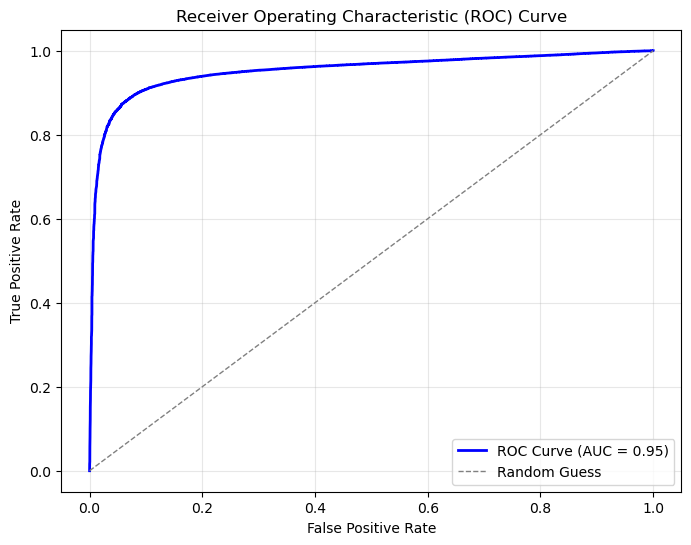

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the true labels and predicted probabilities from results
y_val = time_series_xgboost_results[0]["y_val"]
y_pred = time_series_xgboost_results[0]["y_pred_probs"][:,1]  # Ensure this contains predicted probabilities for the positive class

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [28]:
file = open('../results/xgboost_best_model.save', 'wb')
pickle.dump(time_series_xgboost_results[0], file)
file.close()

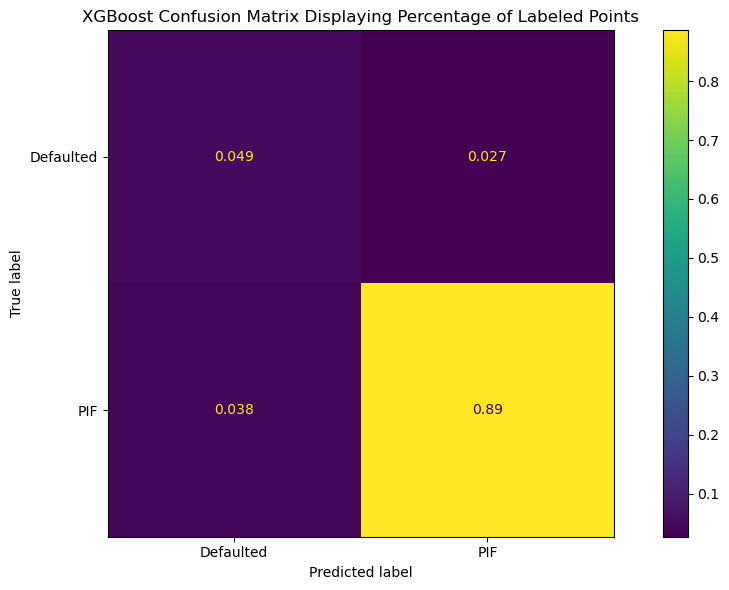

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extract true labels and predicted labels
y_true = time_series_xgboost_results[0]["y_val"]
y_pred = time_series_xgboost_results[0]["y_pred"]
    
cm = confusion_matrix(y_true, y_pred)
cm = cm / (np.sum(cm[0]) + np.sum(cm[1]))

disp = ConfusionMatrixDisplay(cm,display_labels=['Defaulted', 'PIF'])
fig, ax = plt.subplots(figsize=(10,6))
disp.plot(ax=ax)
plt.title("XGBoost Confusion Matrix Displaying Percentage of Labeled Points")
plt.tight_layout()
plt.savefig('../figures/cm.png', dpi=300, bbox_inches='tight')
plt.show()


In [30]:
from sklearn.inspection import permutation_importance

model = time_series_xgboost_results[0]['models'][0]
model_preprocessor = model.named_steps['preprocessor']
score = np.mean(time_series_xgboost_results[0]['f1_scores'])

X_test = time_series_xgboost_results[0]['X_val']
X_test_preprocessed = model_preprocessor.transform(X_test)
feature_names = model_preprocessor.get_feature_names_out()
X_test_preprocessed = pd.DataFrame(data=X_test_preprocessed.toarray(),columns = feature_names)

y_test = time_series_xgboost_results[0]['y_val']
results = permutation_importance(model.named_steps['classifier'], X_test_preprocessed, y_test, n_repeats=5, random_state=0)
importances = results["importances"]
importances_mean = results["importances_mean"]
importances_std = results["importances_std"]

sorted = np.argsort(importances_mean)[-1:-11:-1]
sorted_features = feature_names[sorted]
sorted_means = importances_mean[sorted]
sorted_importances = importances[sorted]

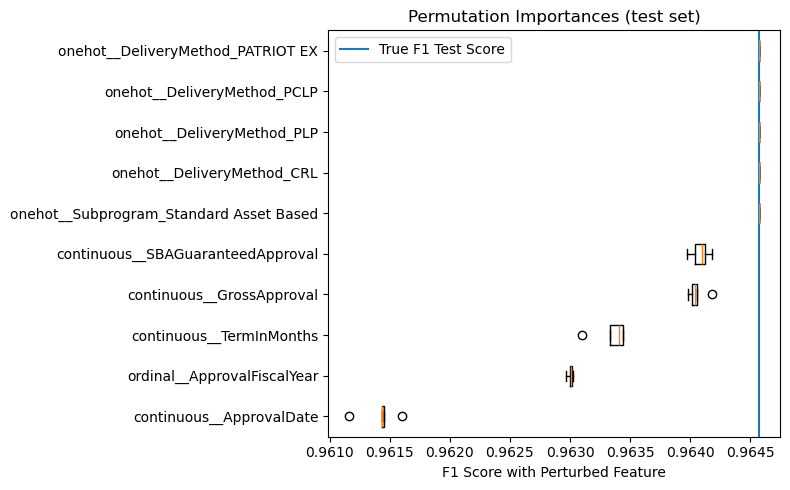

In [31]:
plt.figure(figsize=(8,5))
plt.boxplot([score - importance for importance in sorted_importances], tick_labels=sorted_features, vert=False)
plt.axvline(score,label="True F1 Test Score")
plt.title("Permutation Importances (test set)")
plt.xlabel("F1 Score with Perturbed Feature")
plt.legend()
plt.tight_layout()
plt.savefig('../figures/Permutation_Importance.png', dpi=300, bbox_inches='tight')
plt.show()

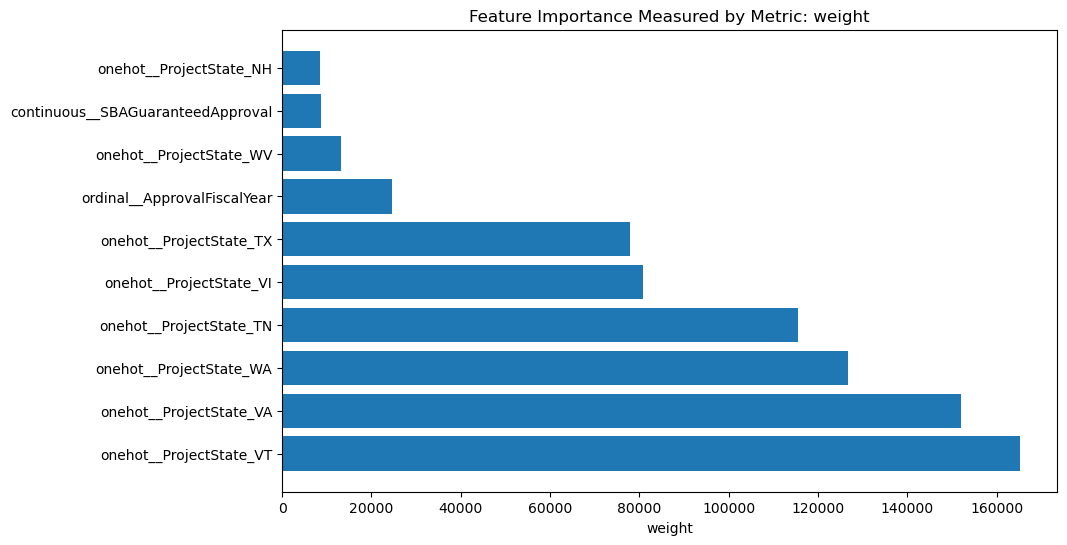

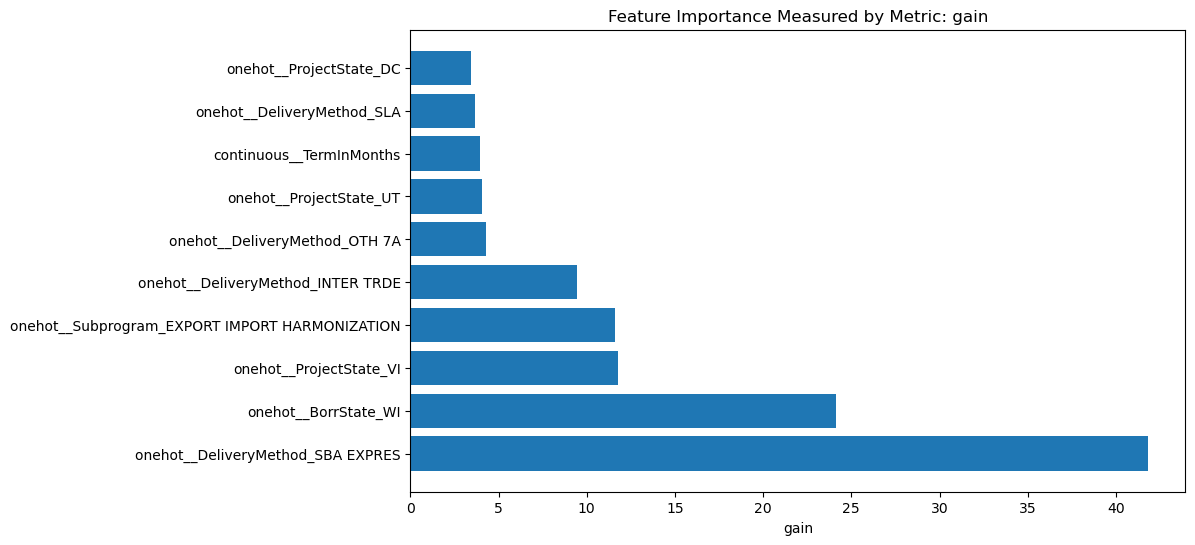

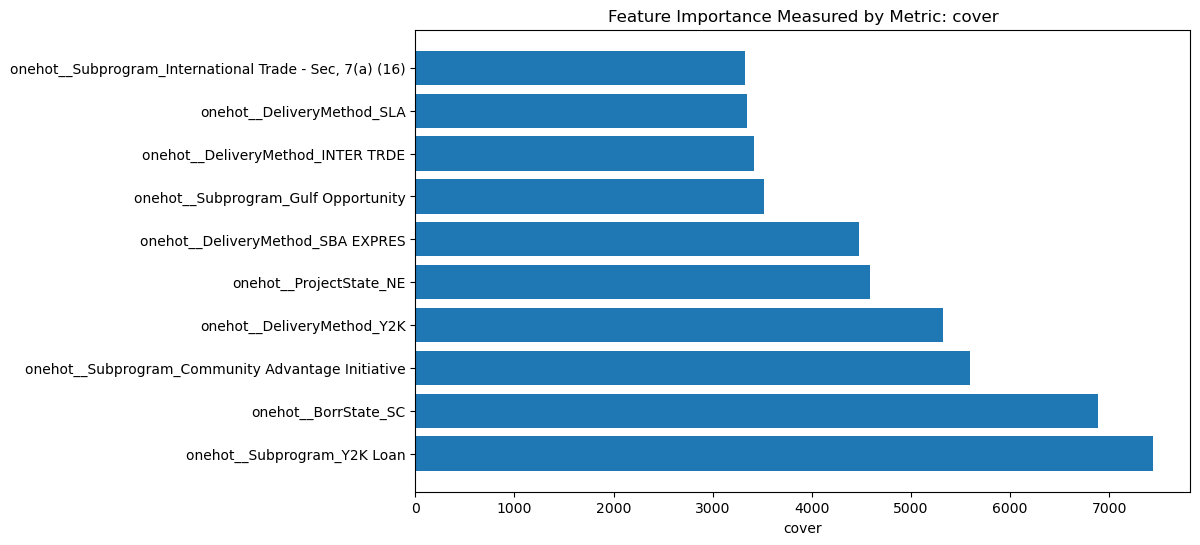

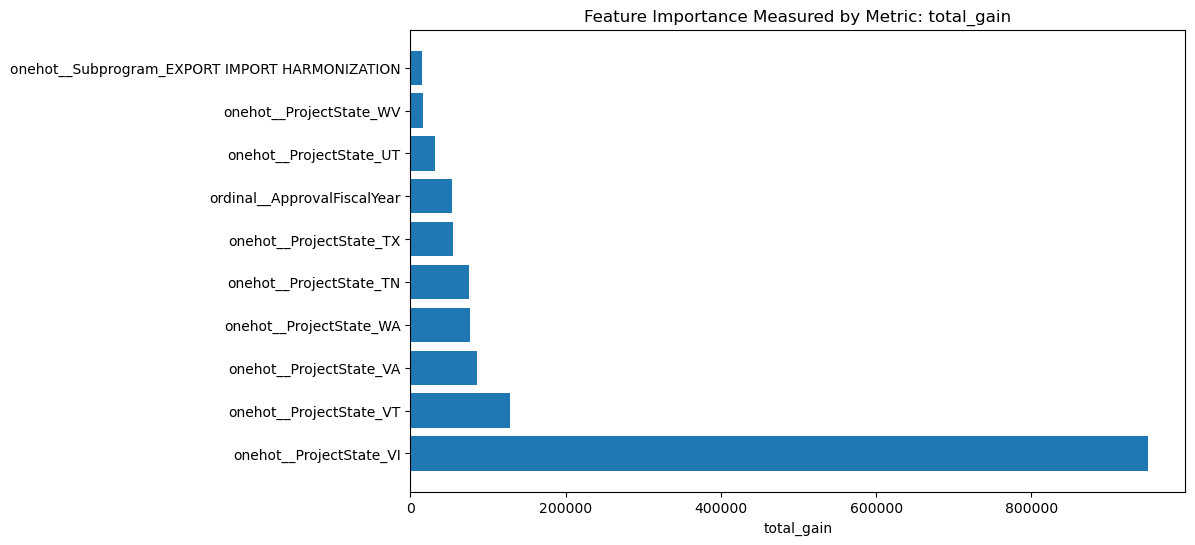

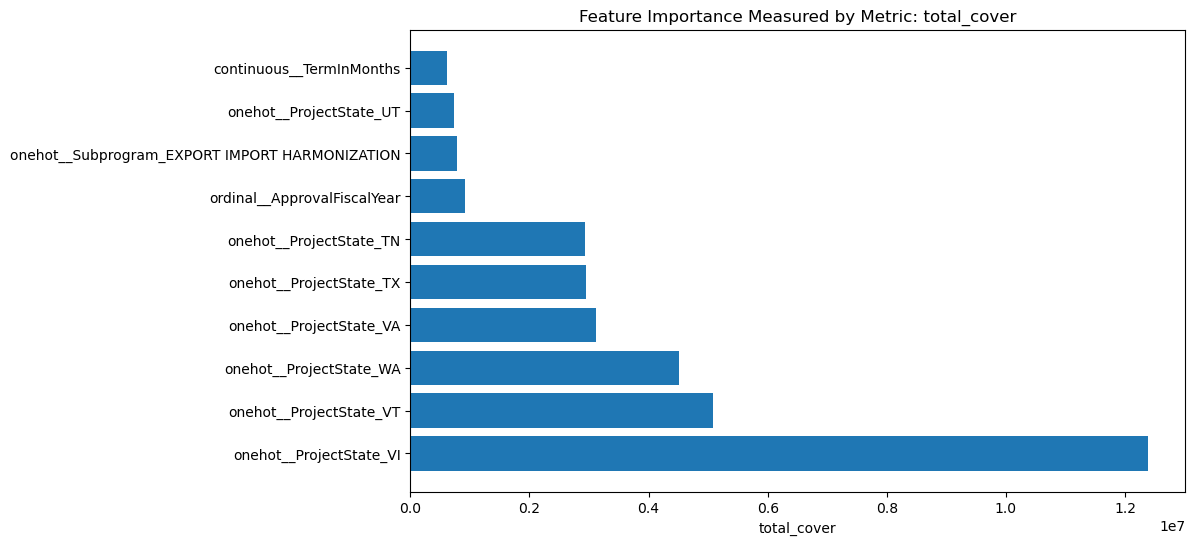

In [32]:
importance_types = ["weight", "gain", "cover", "total_gain", "total_cover"]

for type in importance_types:
    score = model.named_steps['classifier'].get_booster().get_score(importance_type=type)
    pure_scores = np.array(list(score.values()))
    sorted = np.argsort(pure_scores)[-1:-11:-1]
    plt.figure(figsize=(10,6))
    plt.barh(feature_names[sorted], pure_scores[sorted])
    plt.title("Feature Importance Measured by Metric: " + type)
    plt.savefig("../figures/Feature_Importance_By_" + type + ".png", dpi=300, bbox_inches='tight')
    plt.xlabel(type)
    plt.show()

In [33]:
import shap

explainer = shap.TreeExplainer(model.named_steps['classifier'], approximate=True)

In [40]:
subset = stratified_subset(X_test_preprocessed, 'ordinal__ApprovalFiscalYear', 0.01, random_state=27, sorted=False)
shap_values = explainer.shap_values(subset)

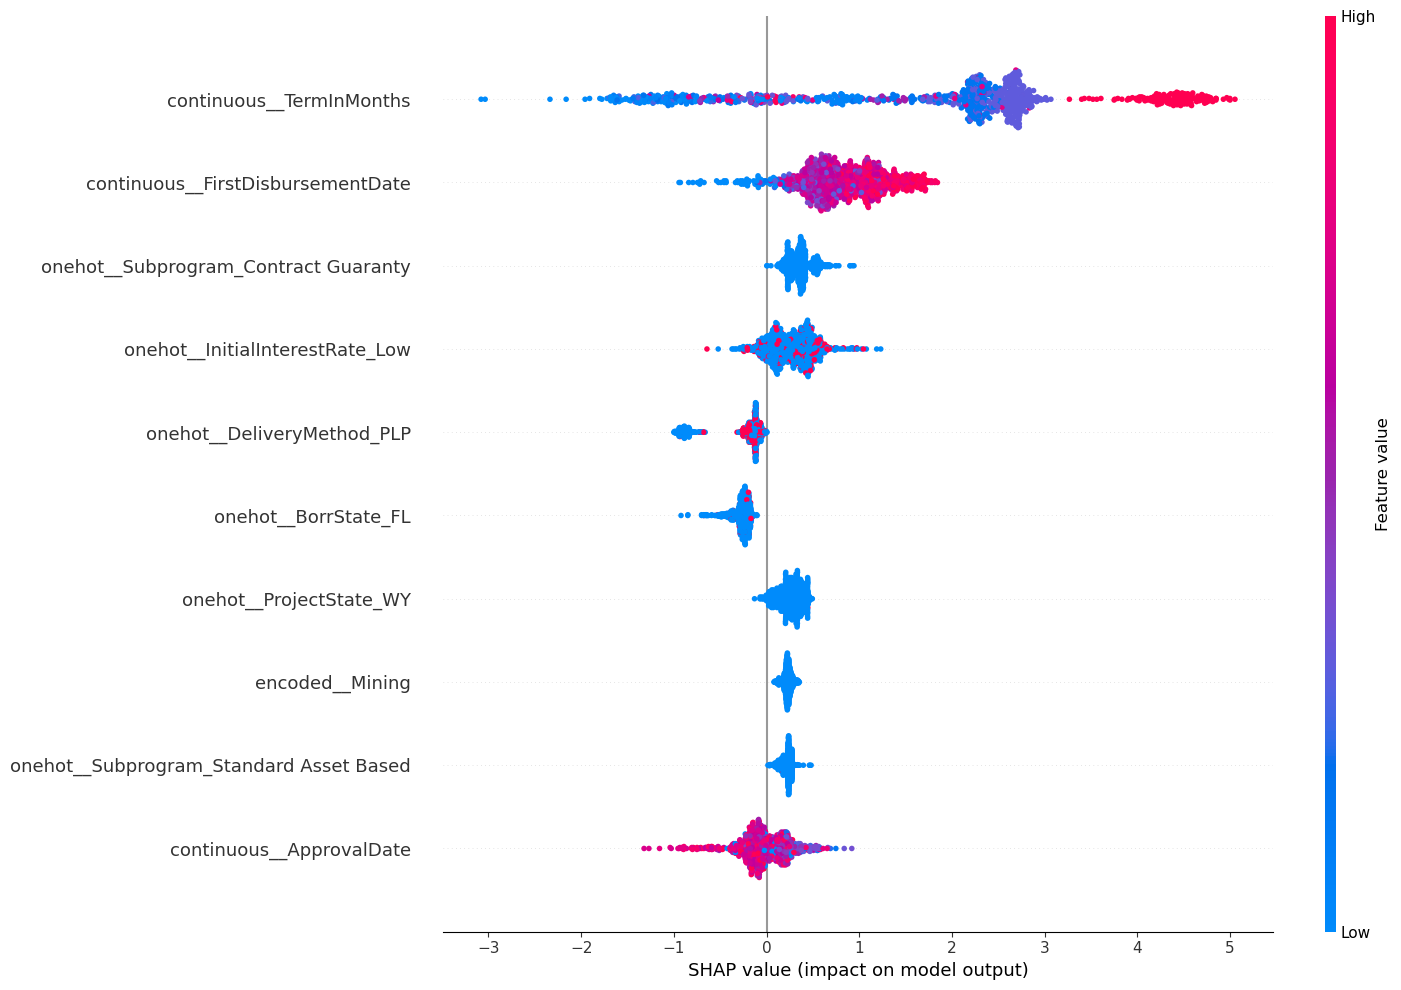

<Figure size 640x480 with 0 Axes>

In [41]:
plt.figure(figsize=(30, 10))
shap.summary_plot(shap_values, subset, max_display=10, plot_size=(15, 10))
plt.savefig('../figures/shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

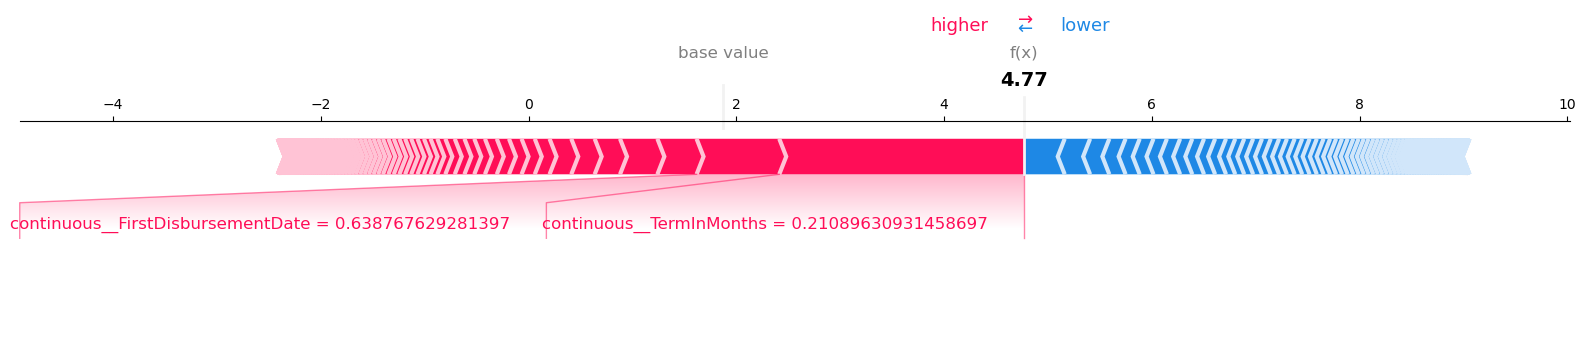

In [45]:
shap.initjs()

plt.figure()
shap.force_plot(
    explainer.expected_value,
    shap_values[1, :],
    features=subset.iloc[1, :],
    feature_names=feature_names,
    matplotlib=True,
    show=False
)
plt.savefig("../figures/force_plot_1.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

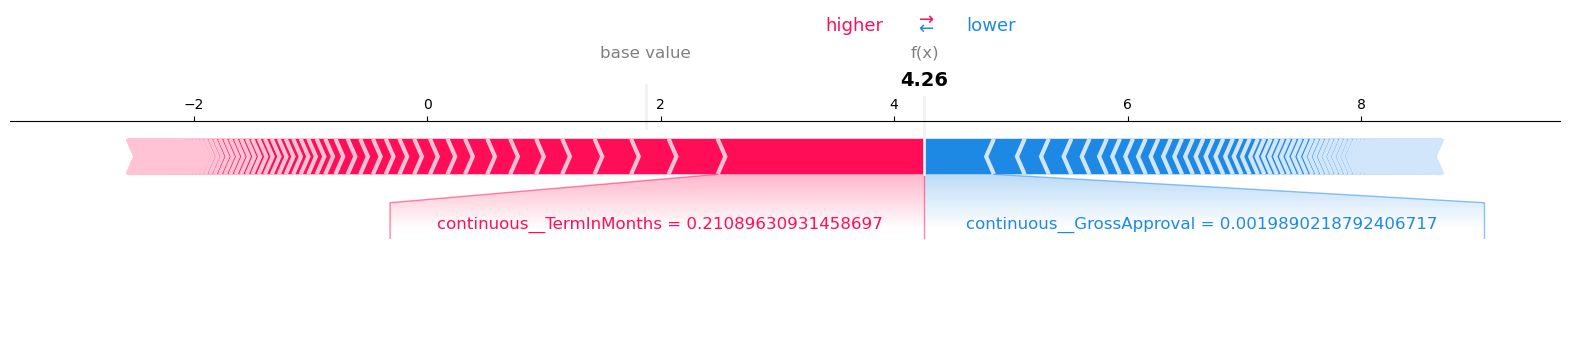

In [46]:
shap.initjs()

plt.figure()
shap.force_plot(
    explainer.expected_value,
    shap_values[3, :],
    features=subset.iloc[3, :],
    feature_names=feature_names,
    matplotlib=True,
    show=False
)
plt.savefig("../figures/force_plot_2.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

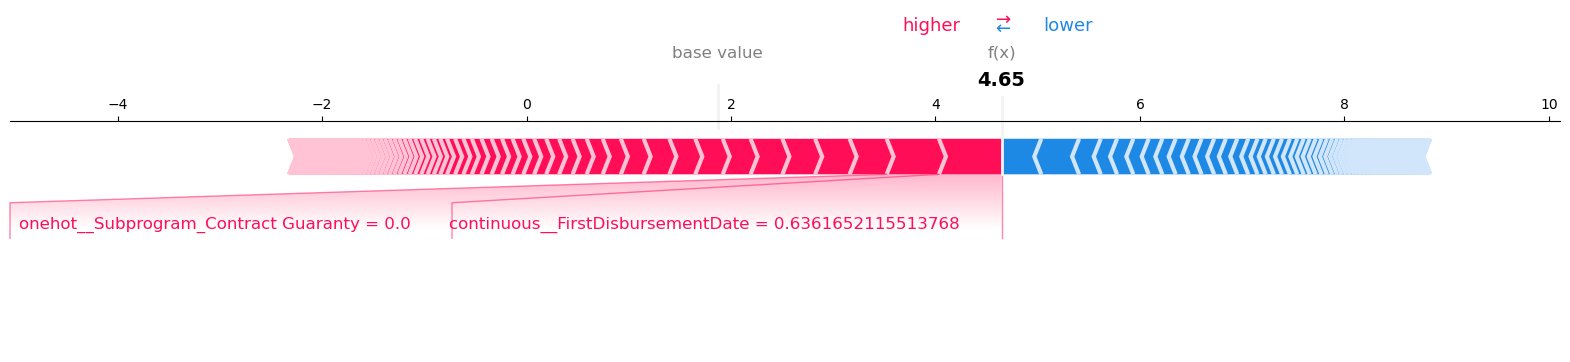

In [47]:
shap.initjs()

plt.figure()
shap.force_plot(
    explainer.expected_value,
    shap_values[20, :],
    features=subset.iloc[20, :],
    feature_names=feature_names,
    matplotlib=True,
    show=False
)
plt.savefig("../figures/force_plot_3.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()